# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1kK03y4YPHnlJKjaAtF3FLu_SDk4ziIuY?usp=sharing

In [37]:
%%shell
jupyter nbconvert --to html /content/Fall_2023_Lab2_Cats_vs_Dogs.ipynb

[NbConvertApp] Converting notebook /content/Fall_2023_Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 1791994 bytes to /content/Fall_2023_Lab2_Cats_vs_Dogs.html


In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

100%|██████████| 170498071/170498071 [00:10<00:00, 16283592.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

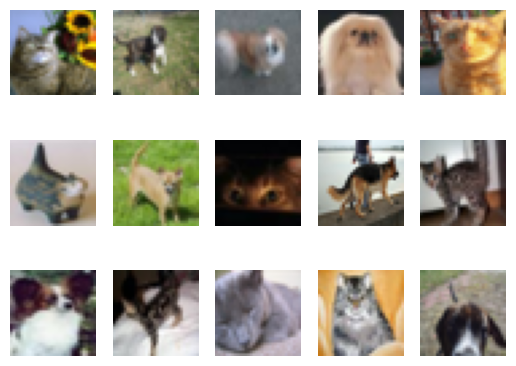

In [4]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [5]:
train_cats = 0
train_dogs = 0

val_cats = 0
val_dogs = 0

test_cats = 0
test_dogs = 0


for images, labels in train_loader:
  for label in labels:
    if label == 3:
      train_cats += 1
    elif label == 5:
      train_dogs += 1

for images, labels in val_loader:
  for label in labels:
    if label == 3:
      val_cats += 1
    elif label == 5:
      val_dogs += 1

for images, labels in test_loader:
  for label in labels:
    if label == 3:
      test_cats += 1
    elif label == 5:
      test_dogs += 1

print("The number of cats in training set is:" ,train_cats)
print("The number of dogs in training set is:" ,train_dogs)

print("The number of cats in validation set is:" ,val_cats)
print("The number of dogs in validation set is:" ,val_dogs)

print("The number of cats in testing set is:" ,test_cats)
print("The number of dogs in testing set is:" ,test_dogs)

The number of cats in training set is: 4018
The number of dogs in training set is: 3982
The number of cats in validation set is: 982
The number of dogs in validation set is: 1018
The number of cats in testing set is: 1000
The number of dogs in testing set is: 1000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need it to prevent bias. If we change parameters solely based on the results from the training data, we will likely overfit the model to work really well on training data set, but poorly when applied to general data.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [6]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [7]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [8]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [9]:
small_params = 0
large_params = 0

for param in small_net.parameters():
  small_params += param.numel()

for param in large_net.parameters():
  large_params += param.numel()

print("Small Network:", small_params)
print("Large Network:", large_params)

Small Network: 386
Large Network: 9705


In [10]:
##Visualising for myself...

for param in small_net.parameters():
    print(param.shape)

print("-------------------------")

for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
-------------------------
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [11]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

The default values are:
Batch Size = 64 //
Learning Rate = 0.01 //
Number of Epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

The following part of the code is what writes files to the disk:

torch.save(net.state_dict(), model_path)

The state_dict() portion saves the values of the model parameters at the time at which the code is run.

Since this part of the code is contained within the epochs for-loop, then five files will be saved to disc when we train for 5 epochs.

Since we would be calling small_net.state_dict(), the five files saved to disc would map each layer in small_net to its parameter tensor (i.e., the tensors containing the weights/biases); so, the values of the parameters at the end of each epoch would be saved.

Each of the five files would contain the parameter tensors for the convolutional and fully connected layers of small_net at the end of the given epoch.

The code also saves .csv files of the training error/loss, and validation error/loss.

In [12]:
# See text above.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [13]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.45425, Train loss: 0.6851070222854614 |Validation err: 0.389, Validation loss: 0.6671865712851286
Epoch 2: Train err: 0.381875, Train loss: 0.6547058038711547 |Validation err: 0.402, Validation loss: 0.6695609744638205
Epoch 3: Train err: 0.35, Train loss: 0.6300666890144349 |Validation err: 0.3485, Validation loss: 0.6256818231195211
Epoch 4: Train err: 0.33225, Train loss: 0.6109677958488464 |Validation err: 0.3585, Validation loss: 0.6330631468445063
Epoch 5: Train err: 0.319125, Train loss: 0.6016905965805054 |Validation err: 0.3355, Validation loss: 0.6257611978799105
Epoch 6: Train err: 0.314, Train loss: 0.5936273777484894 |Validation err: 0.331, Validation loss: 0.6176163405179977
Epoch 7: Train err: 0.314625, Train loss: 0.5908188660144806 |Validation err: 0.335, Validation loss: 0.6120358584448695
Epoch 8: Train err: 0.30875, Train loss: 0.5854076492786408 |Validation err: 0.33, 

In [17]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.494375, Train loss: 0.6930887951850891 |Validation err: 0.4485, Validation loss: 0.690829636529088
Epoch 2: Train err: 0.457125, Train loss: 0.6892735781669617 |Validation err: 0.429, Validation loss: 0.6848130244761705
Epoch 3: Train err: 0.4365, Train loss: 0.6830823998451233 |Validation err: 0.414, Validation loss: 0.6775977332144976
Epoch 4: Train err: 0.42275, Train loss: 0.6734163565635681 |Validation err: 0.4005, Validation loss: 0.6661468110978603
Epoch 5: Train err: 0.399125, Train loss: 0.663463879108429 |Validation err: 0.393, Validation loss: 0.6588453389704227
Epoch 6: Train err: 0.376125, Train loss: 0.6488657274246216 |Validation err: 0.374, Validation loss: 0.6468996237963438
Epoch 7: Train err: 0.371875, Train loss: 0.6397379412651062 |Validation err: 0.382, Validation loss: 0.6475604772567749
Epoch 8: Train err: 0.35725, Train loss: 0.6253787627220154 |Validation err: 0.3

It took 87.87 seconds to train small_net.

It took 103.55 seconds to train large_net.

It took longer to train large_net because it has more parameters than small_net.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

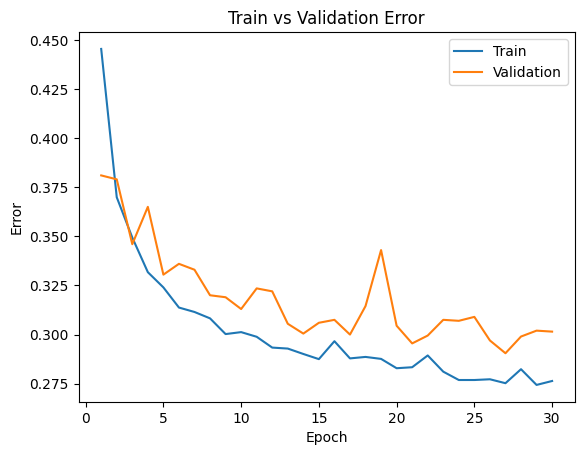

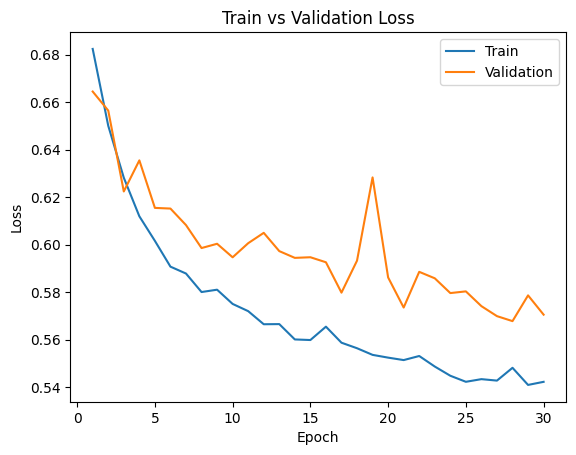

In [16]:
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)

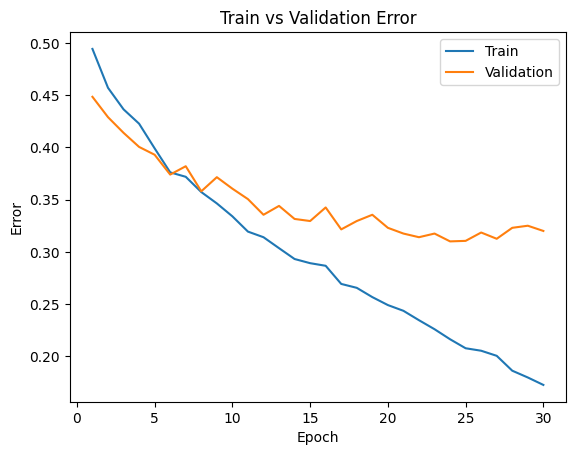

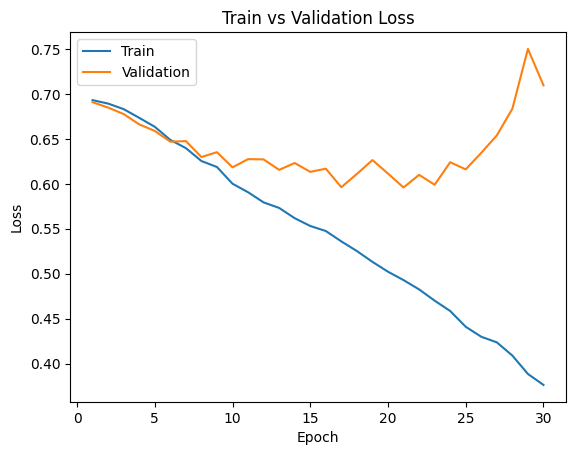

In [18]:
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

The small_net training curves for both error and loss decrease at a decreasing rate over the course of the training. In other words, as training progresses, the training error/loss begins to plateau as we reach 30 epochs. A similar trend can be seen with the validation curves of small_net; the validation error/loss decrease at a decreasing rate as epochs increase (save for some spikes here and there, but overall the validaiton loss/error decreases).

The large_net training curves for both error and loss seem to consistently decrease as the epochs increase, showing no signs of plateauing. As for the large_net validation curves, the validation error plateaus at a level much higher (i.e., larger error) compared to the training error which only decreases (and does not plateau). The validation loss curve exhibits a more extreme behaviour, as it actually begins to increase after about 20 epochs. The fact that the training loss decreases consistently while the validation loss begings to increase shows that we are overfitting the model; the model is memorising the training set and can thus not generalise to the validation set.

In [19]:
# See text above.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360028266907 |Validation err: 0.467, Validation loss: 0.6924686599522829
Epoch 2: Train err: 0.448625, Train loss: 0.6922589740753173 |Validation err: 0.4305, Validation loss: 0.6916493307799101
Epoch 3: Train err: 0.43575, Train loss: 0.6916067419052124 |Validation err: 0.4285, Validation loss: 0.6908544395118952
Epoch 4: Train err: 0.430125, Train loss: 0.6908613877296448 |Validation err: 0.424, Validation loss: 0.6896596923470497
Epoch 5: Train err: 0.434125, Train loss: 0.6899198365211486 |Validation err: 0.4195, Validation loss: 0.6886942777782679
Epoch 6: Train err: 0.435875, Train loss: 0.6887419753074646 |Validation err: 0.4195, Validation loss: 0.6867837514728308
Epoch 7: Train err: 0.436625, Train loss: 0.6873781814575195 |Validation err: 0.4185, Validation loss: 0.6851996649056673
Epoch 8: Train err: 0.43725, Train loss: 0.6859267921447754 |Validation er

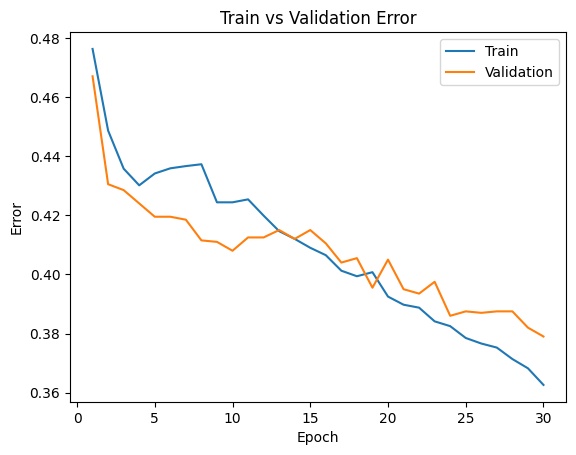

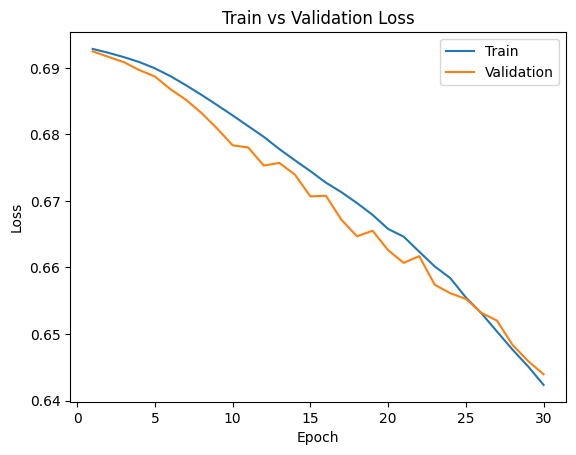

In [32]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate = 0.001)

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

Lowering the learning rate resulted in no overfitting, as shown by the fact that the validation and training curves for both error and loss decrease similarly, and the validation curve does not show signs of increasing. However, increasing the learning rate overall increased the values of error and loss for training at 30 epochs; this may be attributed to the lack of overfitting,and arguably underfitting, as we see that the validation loss curve is actually a bit lower than the training one.

This model took a few seconds less time to train than the model with the larger learning rate; this is unexpected as one would expect training time to increase as learning rate decreases, as we are taking smaller steps when optimising.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.6743808498382569 |Validation err: 0.3565, Validation loss: 0.6350402869284153
Epoch 2: Train err: 0.364375, Train loss: 0.6394594783782959 |Validation err: 0.364, Validation loss: 0.6380155384540558
Epoch 3: Train err: 0.357125, Train loss: 0.6292509632110596 |Validation err: 0.357, Validation loss: 0.6313505992293358
Epoch 4: Train err: 0.351375, Train loss: 0.6222558770179748 |Validation err: 0.3615, Validation loss: 0.6581139843910933
Epoch 5: Train err: 0.3425, Train loss: 0.6109966540336609 |Validation err: 0.327, Validation loss: 0.593532383441925
Epoch 6: Train err: 0.31975, Train loss: 0.5888414912223816 |Validation err: 0.3045, Validation loss: 0.6088876193389297
Epoch 7: Train err: 0.31825, Train loss: 0.5887727000713349 |Validation err: 0.3255, Validation loss: 0.6114899981766939
Epoch 8: Train err: 0.310125, Train loss: 0.5762689855098725 |Validation err: 0.

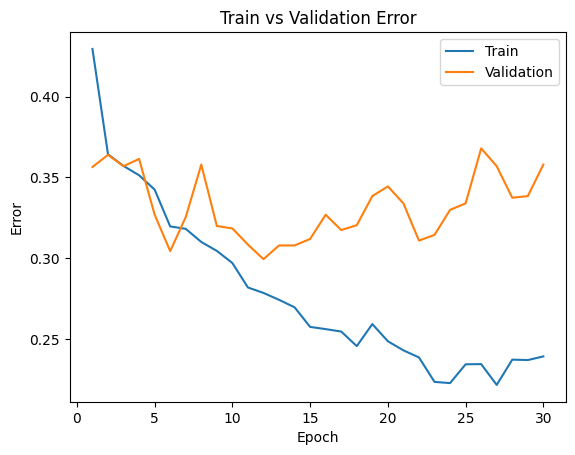

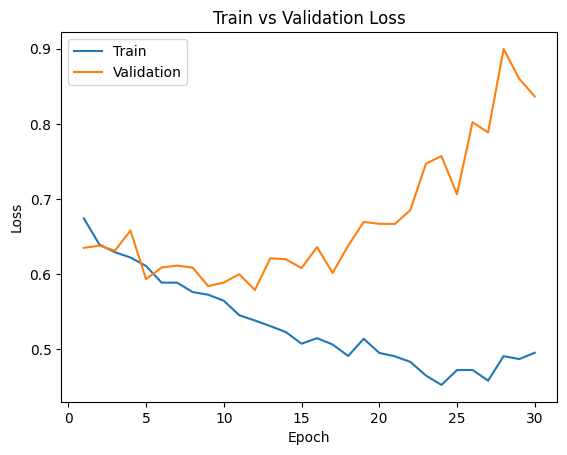

In [33]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)

large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

Increasing the learning rate caused a lot of overfitting of the model; this is evident due to the validation error and loss shooting up after only about 10 epochs. By the time we reach 30 epochs, the validation loss is about 0.9. Increasing the learning rate from the original 0.01 was detrimental.

This model took about the same time to train as the model with learning rate of 0.001; again, this is unexpected as larger steps are taken with a larger learning rate, meaning one would expect training to complete faster.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379515349865 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870153188705
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.6883531995117664 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871826350689 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.411, Va

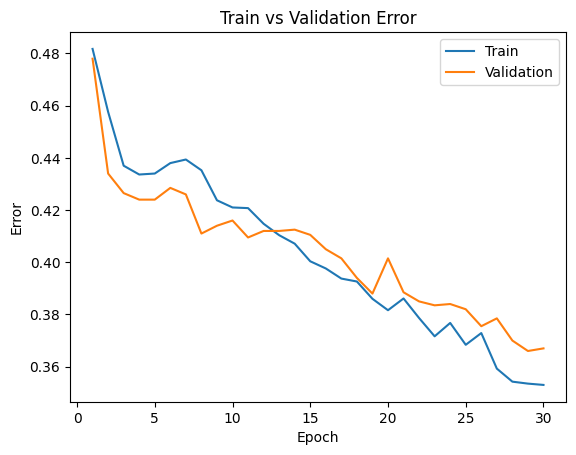

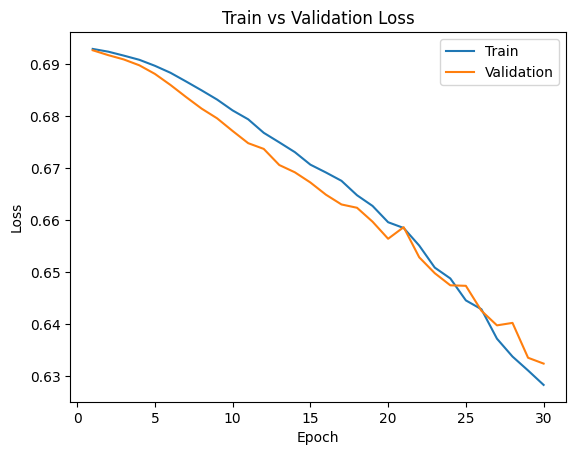

In [34]:
large_net = LargeNet()
train_net(large_net, batch_size = 512)

large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

Using the learning rate of 0.01 with a much larger batch size resulted in underfitting the model; this is evident because neither the training or validation curves are converging for loss nor error, and the validation loss is beneath the training loss for the most part. It is possible that increasing the number of epochs would eventually result in convergence. Training this model took less time than the original (87.44 seconds as opposed to 103.55 seconds). This is expected due to less calculations having to be done to complete one epoch; an larger batch size means less updating of weights/biases to run through the available training/validation data.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775506158471107 |Validation err: 0.378, Validation loss: 0.6512571625709533
Epoch 2: Train err: 0.3655, Train loss: 0.6395608481168747 |Validation err: 0.353, Validation loss: 0.6191524927616119
Epoch 3: Train err: 0.339875, Train loss: 0.6127814228534698 |Validation err: 0.3495, Validation loss: 0.6442944076061249
Epoch 4: Train err: 0.31475, Train loss: 0.5870258185863495 |Validation err: 0.3385, Validation loss: 0.5978640830516815
Epoch 5: Train err: 0.303, Train loss: 0.5651368154883385 |Validation err: 0.305, Validation loss: 0.5715659594535828
Epoch 6: Train err: 0.29025, Train loss: 0.5493593747615815 |Validation err: 0.302, Validation loss: 0.5801575357913971
Epoch 7: Train err: 0.26925, Train loss: 0.5272505192756652 |Validation err: 0.3005, Validation loss: 0.5818900580406189
Epoch 8: Train err: 0.254375, Train loss: 0.5104012369215488 |Validation err: 0.31

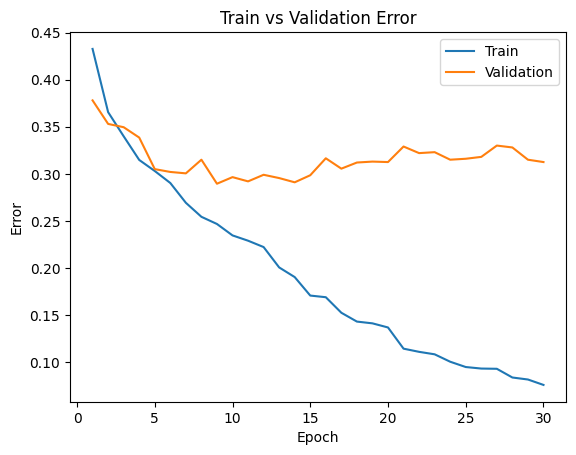

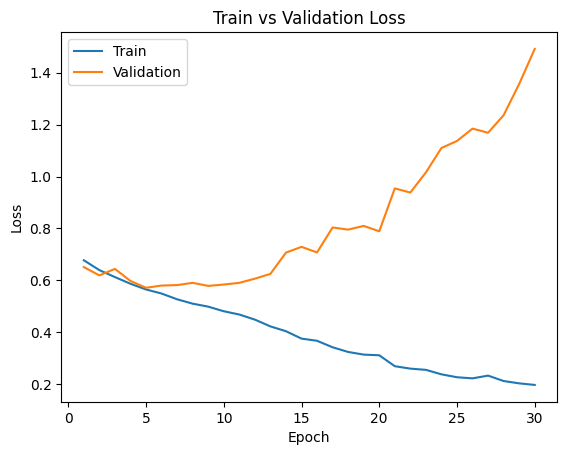

In [35]:
large_net = LargeNet()
train_net(large_net, batch_size = 16)

large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

Decreasing the batch size to 16 while maintaining the original learning rate of 0.01 resulted in overfitting. This is evident due to the fact that low values of error/loss were achieved on the training set, while error for the validation set plateaued and loss for the validaiton set increased steeply after about 10 epochs. Having a small batch size may cause overfitting as the loss is calculated based on more specific images, rather than more general batches. As such, the model may find it difficult to generalise. This model also took longer to train (146.32 seconds), which is expected since many more calculations were done to complete one epoch of training (smaller batch size means it takes longer to run through the whole training/validation sets).

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the plots above, I would choose to use a learning rate of 0.001, as it was the only learning rate tested that did not overfit the model. I will also use a batch size of 128, as larger batch sizes seemed to prevent overfitting; I chose 128 as using a batch size too large (such as 512) resulted in underfitting. Finally, I will train the model for 60 epochs instead of 30 to see if training for longer would result in better performance; for the model which used learning rate of 0.001 and batch size of 64, there did not appear to be any convergence after 30 epochs, so I will see the impact of increasing epochs.

In [ ]:
# See text above.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.471, Train loss: 0.6924877185670156 |Validation err: 0.4695, Validation loss: 0.6924382708966732
Epoch 2: Train err: 0.45325, Train loss: 0.692097856884911 |Validation err: 0.4555, Validation loss: 0.6918724104762077
Epoch 3: Train err: 0.44275, Train loss: 0.6916988955603706 |Validation err: 0.4375, Validation loss: 0.6914208754897118
Epoch 4: Train err: 0.434125, Train loss: 0.69117795380335 |Validation err: 0.4255, Validation loss: 0.6908281370997429
Epoch 5: Train err: 0.427625, Train loss: 0.6906440674312531 |Validation err: 0.421, Validation loss: 0.6901085935533047
Epoch 6: Train err: 0.42775, Train loss: 0.6899746315819877 |Validation err: 0.4285, Validation loss: 0.6893323138356209
Epoch 7: Train err: 0.431625, Train loss: 0.689231949193137 |Validation err: 0.4255, Validation loss: 0.6882652938365936
Epoch 8: Train err: 0.435625, Train loss: 0.6884165169700743 |Validation err: 0.4

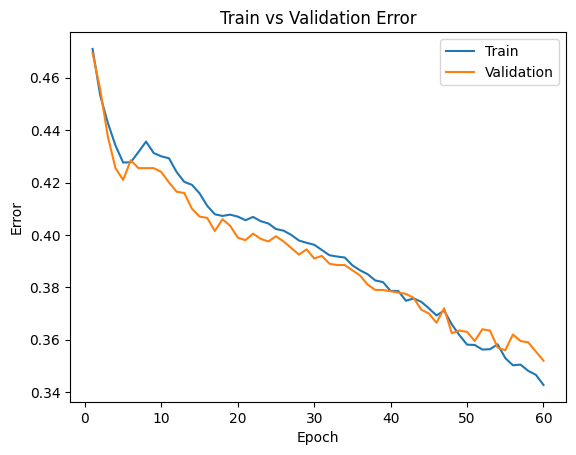

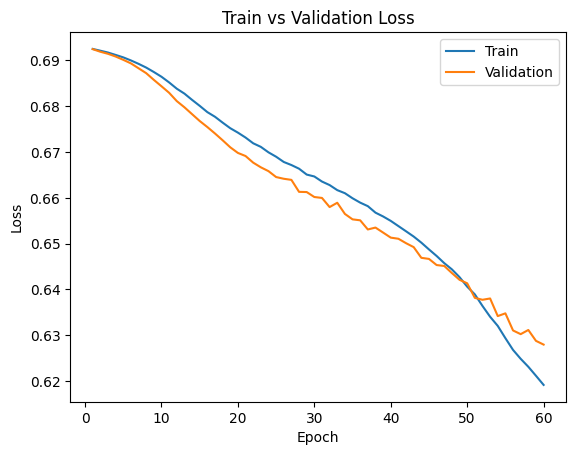

In [12]:
large_net = LargeNet()
train_net(large_net, batch_size = 128, learning_rate = 0.001, num_epochs = 60)

large_model_path = get_model_name("large", batch_size=128, learning_rate=0.001, epoch=59)
plot_training_curve(large_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

Comparing the above resutls to the model of learning rate = 0.001, batch size = 64, and epochs = 30, there was not much improvement. The loss/error values at the end of the training were only slightly lower (0.36 vs about 0.34) than those of the previous model, and there was no sign of plateau at 60 epochs. I will now try to use the same batch size and learning rate while increasing the epochs to 180. I have chosen this route as, although there was only a bit of improvement when changing the batch size to 128 from 64, and epochs from 30 to 60, I believe that significantly increasing epochs may lead to further reductions and convergence/plateau of error/loss values.

In [ ]:
# See text above.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.484, Train loss: 0.6929682918957302 |Validation err: 0.4885, Validation loss: 0.6928678974509239
Epoch 2: Train err: 0.470875, Train loss: 0.6926813135071407 |Validation err: 0.4605, Validation loss: 0.6924122832715511
Epoch 3: Train err: 0.456625, Train loss: 0.6924002776070247 |Validation err: 0.4465, Validation loss: 0.6921139881014824
Epoch 4: Train err: 0.448, Train loss: 0.6920825905270047 |Validation err: 0.429, Validation loss: 0.6917431652545929
Epoch 5: Train err: 0.438625, Train loss: 0.6917580403978862 |Validation err: 0.428, Validation loss: 0.6913251988589764
Epoch 6: Train err: 0.4335, Train loss: 0.6914141272741651 |Validation err: 0.428, Validation loss: 0.6909378096461296
Epoch 7: Train err: 0.43725, Train loss: 0.6910447904041835 |Validation err: 0.4255, Validation loss: 0.690433606505394
Epoch 8: Train err: 0.439625, Train loss: 0.6906505927206978 |Validation err: 0.425

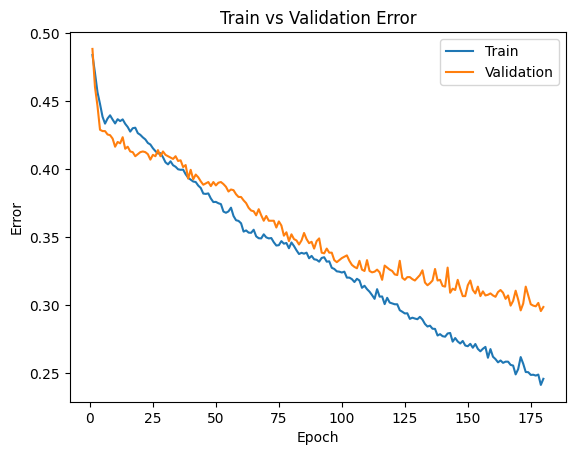

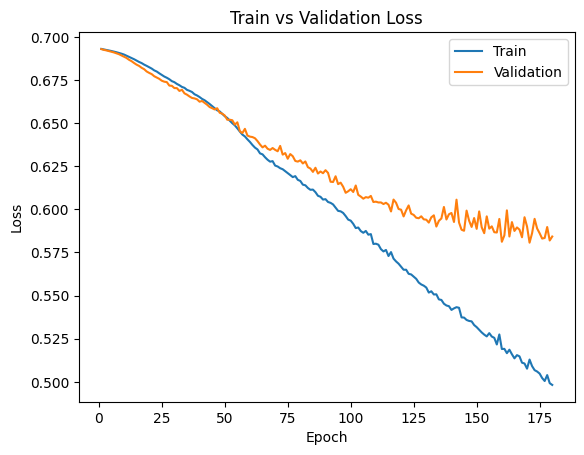

In [16]:
large_net = LargeNet()
train_net(large_net, batch_size = 128, learning_rate = 0.001, num_epochs = 180)

large_model_path = get_model_name("large", batch_size=128, learning_rate=0.001, epoch=179)
plot_training_curve(large_model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [17]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.001, epoch=179)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I chose this final model as the best model as it did not exbihit overfitting (the validation error/loss only seem to start to plateau, but not increase/show any upward trends), nor did it exhibit underfitting (the training loss/error was consistently below the validation loss/error). Also, this model achieves lower validation error (about 0.28) than the other models.

In [ ]:
# See text above.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [18]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

criterion = nn.BCEWithLogitsLoss()

test_error, test_loss = evaluate(net, test_loader, criterion)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
print('The test error is', test_error)
print('------------------')
print('The test loss is', test_loss)

The test error is 0.2965
------------------
The test loss is 0.5562839284539223


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test error is actually quite close to the validation error; the two seem to be about the same. We expect the test error to be higher than the validation error as the "best" model was chosen based on tuning hyperparameters on the validation set performance. In other words, we tweaked the model based on its performance on the validation set. As such, one would expect that the model would perform a bit worse on data it has never seen. In this case, the extreme similarilty between validation error and test error may be attributed to the robustness of the model (its ability to generalise to never before seen data), as well as potentially similarity between the test and validation images (it is possible that coincidentally the types of images in the validation and test sets were very similar/had very similar features).

In [ ]:
# See text above.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

We only use the test data at the very end because we do not want to introduce bias to our model. If the model sees the test data more than one, it can introduce bias and result in overfitting to the test data. Thus, once the model is used on other, never before seen data, it will likely have worse performance. If the model sees the test data prior to actual testing, the testing results (i.e., test error/loss) would not reflect real world efficacy of the model (i.e., real world error/loss would be worse).

In [ ]:
# See text above.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [25]:
class TwoLayerANN(nn.Module):
    def __init__(self):
        super(TwoLayerANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)

    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)

        return activation2

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.425375, Train loss: 0.6823381289603219 |Validation err: 0.4145, Validation loss: 0.6734195128083229
Epoch 2: Train err: 0.40125, Train loss: 0.668478336599138 |Validation err: 0.4065, Validation loss: 0.6650874242186546
Epoch 3: Train err: 0.395625, Train loss: 0.6614894980476016 |Validation err: 0.403, Validation loss: 0.6619544066488743
Epoch 4: Train err: 0.390625, Train loss: 0.656390613033658 |Validation err: 0.4005, Validation loss: 0.657891046255827
Epoch 5: Train err: 0.382625, Train loss: 0.6522661192076546 |Validation err: 0.3985, Validation loss: 0.6562244519591331
Epoch 6: Train err: 0.380625, Train loss: 0.6493990355067782 |Validation err: 0.4, Validation loss: 0.6555579267442226
Epoch 7: Train err: 0.378625, Train loss: 0.6463190203621274 |Validation err: 0.396, Validation loss: 0.6534174047410488
Epoch 8: Train err: 0.372875, Train loss: 0.643532323458838 |Validation err: 0.

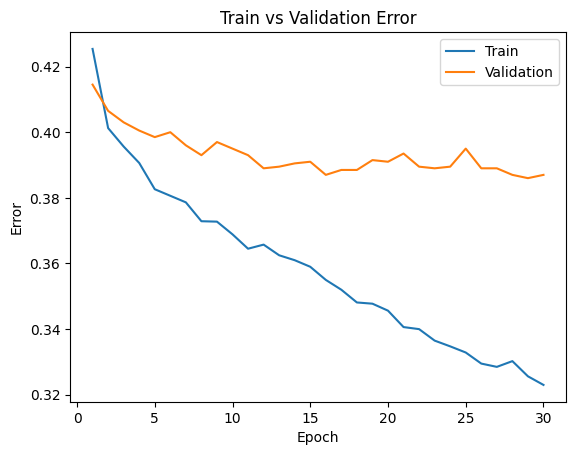

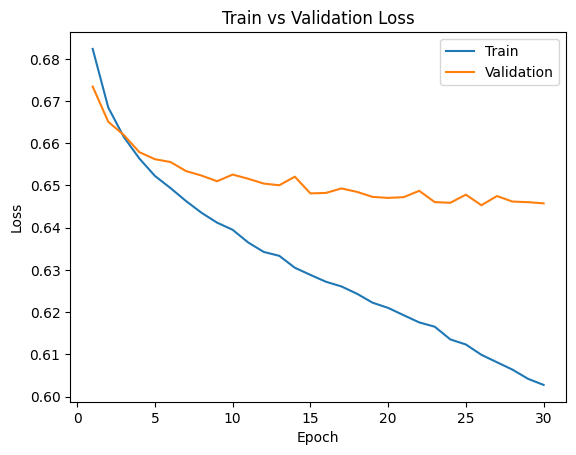

In [35]:
ANN = TwoLayerANN()
train_net(ANN, batch_size=128, learning_rate=0.001, num_epochs=30)

ANN_model_path = get_model_name("ANN", batch_size=128, learning_rate=0.001, epoch=29)
plot_training_curve(ANN_model_path)

I tried the following combinations:

1. Batch size = 128, learning rate = 0.001, epochs = 60 ||
This resulted in validation error/loss that did not really decrease much as epochs continued; validation error ~ 0.375

2. Batch size = 256, learning rate = 0.001, epochs = 30 ||
This resulted in validation error ~ 0.4

3. Batch size = 256, learning rate = 0.01, epochs = 30 ||
This resulted in validation error ~ 0.4 and clear overfitting.

4. Batch size = 512, learning rate = 0.001, epochs = 30 ||
This resulted in validation error ~ 0.41

5. Batch size = 64, learning rate = 0.001, epochs = 30 ||
This resulted in validation error ~ 0.38

6. Batch size = 128, learning rate = 0.002, epochs = 30 ||
This resulted in validation error ~ 0.38

Will go with the first option but reduce epochs to 30, as 90 epochs did not really do much (validation loss/error plateaued pretty early on in training).



In [36]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=128)

criterion = nn.BCEWithLogitsLoss()

test_error, test_loss = evaluate(ANN, test_loader, criterion)

print('The test error for the ANN is', test_error)
print('The test loss for the ANN is', test_loss)

Files already downloaded and verified
Files already downloaded and verified
The test error for the ANN is 0.357
The test loss for the ANN is 0.6369707994163036


The test error for the ANN was a bit lower than the validation error (about 0.35 for testing vs about 0.39 for validation). However, the ANN performed worse in comparison to the CNN, as the test error for the CNN model was about 0.3.